In [16]:
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import cv2

In [17]:
# Load your colored image
image_path = '3-13.jpg'
original_image = Image.open(image_path)

In [18]:
img = original_image.resize((200, 200))  # Resize the input image to 200x200 pixels
img = img.convert('L')  # Convert the image to grayscale (Luminance) mode
img_array = np.array(img)  # Convert the image data to a NumPy array
img_array = img_array.reshape((1, 200, 200, 1))  # Reshape the image array to match the input shape expected by the model (200x200 size, 1 channel)
img_array = img_array / 255.0  # Normalize pixel values to the range [0, 1]
print(img_array.shape)

(1, 200, 200, 1)


In [19]:
# Perform age prediction using model1
model1 = tf.keras.models.load_model('age_model_acc_0.587.h5')
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 198, 198, 32)      320       
                                                                 
 batch_normalization_6 (Bat  (None, 198, 198, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 99, 99, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 batch_normalization_7 (Bat  (None, 97, 97, 64)        256 

In [20]:
# Create a submodel that includes the convolutional base and outputs from the desired layers
conv_base = Model(inputs=model1.input, outputs=model1.get_layer('conv2d_8').output)
dense_layer = model1.get_layer('dense_5')
class_weights = dense_layer.get_weights()[0]

In [21]:
# Get the convolutional output
conv_output = conv_base.predict(img_array)

1/1 [==============================] - 0s 85ms/step


In [22]:
# Global average pool the convolutional output
global_avg_pooling = np.mean(conv_output, axis=(1, 2))

In [23]:
# Calculate the class activation map for each class
class_activation_maps = []
for class_index in range(class_weights.shape[1]):
    class_weight = class_weights[:, class_index]
    class_activation_map = np.dot(global_avg_pooling, class_weight)
    class_activation_maps.append(class_activation_map)

In [24]:
# Stack the individual class activation maps
class_activation_map = np.stack(class_activation_maps, axis=1)

In [25]:
# Normalize the class activation map
normalized_cam = (class_activation_map - np.min(class_activation_map)) / (np.max(class_activation_map) - np.min(class_activation_map))

In [26]:
# Resize the CAM to the original image size
resized_cam = cv2.resize(normalized_cam, (original_image.size[0], original_image.size[1]))

In [27]:
# Apply colormap to the CAM
colormap = plt.get_cmap('jet')
colored_cam = colormap(resized_cam)

In [28]:
# Convert the colored CAM to a PIL image
colored_cam_pil = Image.fromarray((colored_cam * 255).astype(np.uint8))

In [29]:
# Overlay the CAM on the original image
overlayed_image = Image.blend(original_image.convert('RGBA'), colored_cam_pil.convert('RGBA'), alpha=0.5)

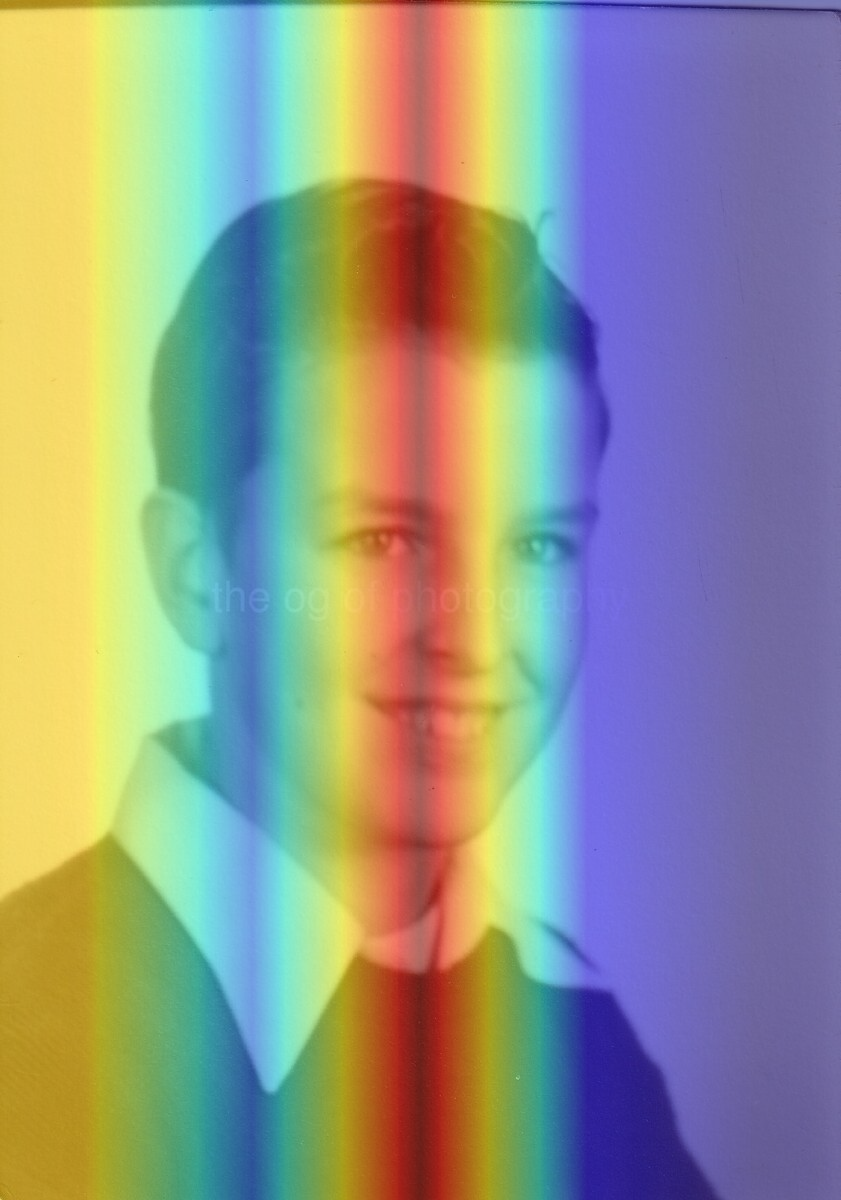

In [30]:
# Save or display the overlayed image
display(overlayed_image)